In [7]:
from google.colab import files
uploaded = files.upload()

Saving Morningstar - European ETFs.csv to Morningstar - European ETFs.csv


In [29]:
import pandas as pd

# Load Excel
df = pd.read_csv("Morningstar - European ETFs.csv")

# Keep relevant columns
df = df[["fund_name", "category", "investment_strategy"]].dropna()
df["investment_strategy"] = df["investment_strategy"].str.lower()

In [30]:
df.head()

,fund_name,category,investment_strategy
0,iShares SMI® ETF (CH),Switzerland Equity,the fund aims to achieve a return on your inve...
1,XACT OMXS30 UCITS ETF,Sweden Equity,the fund is an exchange-traded index fund and ...
2,iShares STOXX Europe 600 Personal & Household ...,Sector Equity Consumer Goods & Services,ishares stoxx europe 600 personal & household ...
3,iShares eb.rexx® Government Germany UCITS ETF ...,EUR Government Bond,ishares eb.rexx government germany (de) is an ...
4,iShares € Corp Bond Large Cap UCITS ETF EUR (D...,EUR Corporate Bond,the investment objective of this fund is to pr...


In [31]:
risk_terms = [
    "credit risk", "liquidity risk", "interest rate", "market volatility",
    "inflation", "foreign exchange", "geopolitical", "regulatory",
    "macroeconomic", "emerging markets", "high yield", "default risk", "esg"
]

def extract_risks(text):
    return [term for term in risk_terms if term in text]

df["extracted_risks"] = df["investment_strategy"].apply(extract_risks)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
X_tfidf = vectorizer.fit_transform(df["investment_strategy"])

In [33]:
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["strategy_cluster"] = kmeans.fit_predict(X_tfidf)

In [34]:
import numpy as np

def get_top_terms(tfidf_matrix, kmeans_model, vectorizer, top_n=10):
    terms = vectorizer.get_feature_names_out()
    keywords = {}
    for i in range(kmeans_model.n_clusters):
        center = kmeans_model.cluster_centers_[i]
        top_terms = [terms[idx] for idx in center.argsort()[-top_n:][::-1]]
        keywords[f"Cluster {i}"] = top_terms
    return keywords

cluster_keywords = get_top_terms(X_tfidf, kmeans, vectorizer)
pd.DataFrame.from_dict(cluster_keywords, orient="index")

,0,1,2,3,4,5,6,7,8,9
Cluster 0,index,performance,fund,investment,expenses,objective,seeks,fees,price,track
Cluster 1,sub,index,error,tracking,performance,fund,minimize,net,value,asset
Cluster 2,index,exchange,etfs,ishares,etf,traded,exposure,liquid,efficient,securities
Cluster 3,return,taking,account,returns,reflects,capital,income,investors,provide,objective
Cluster 4,shares,companies,index,reflect,basis,companys,aim,designed,daily,value


In [35]:
risk_weights = {
    "credit risk": 2,
    "liquidity risk": 2,
    "interest rate": 1,
    "market volatility": 1,
    "inflation": 1,
    "foreign exchange": 1,
    "geopolitical": 2,
    "regulatory": 2,
    "macroeconomic": 1,
    "emerging markets": 3,
    "high yield": 2,
    "default risk": 2,
    "esg": 1
}

def compute_risk_score(risks):
    return sum(risk_weights.get(r, 1) for r in risks)

df["risk_score"] = df["extracted_risks"].apply(compute_risk_score)

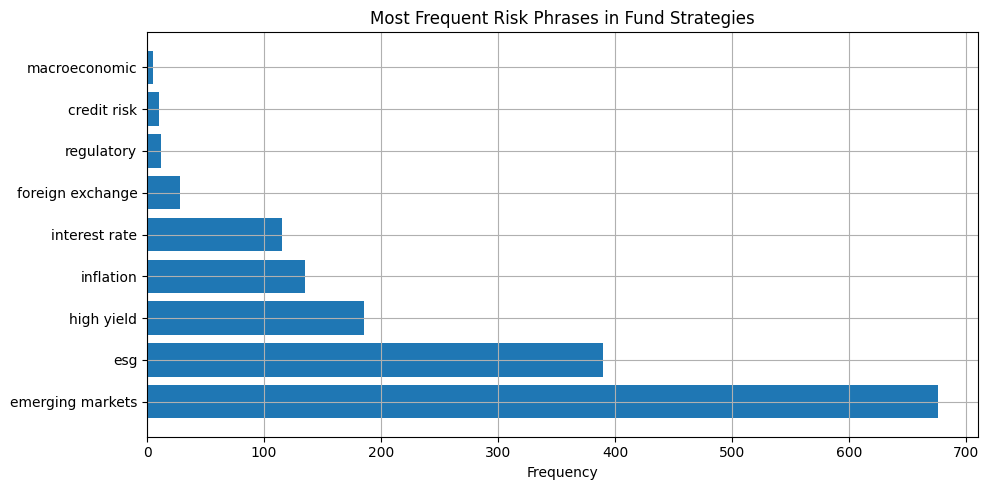

In [36]:
import matplotlib.pyplot as plt
from collections import Counter

all_risks = [r for risks in df["extracted_risks"] for r in risks]
risk_counts = Counter(all_risks)

plt.figure(figsize=(10, 5))
plt.barh(*zip(*risk_counts.most_common()))
plt.title("Most Frequent Risk Phrases in Fund Strategies")
plt.xlabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

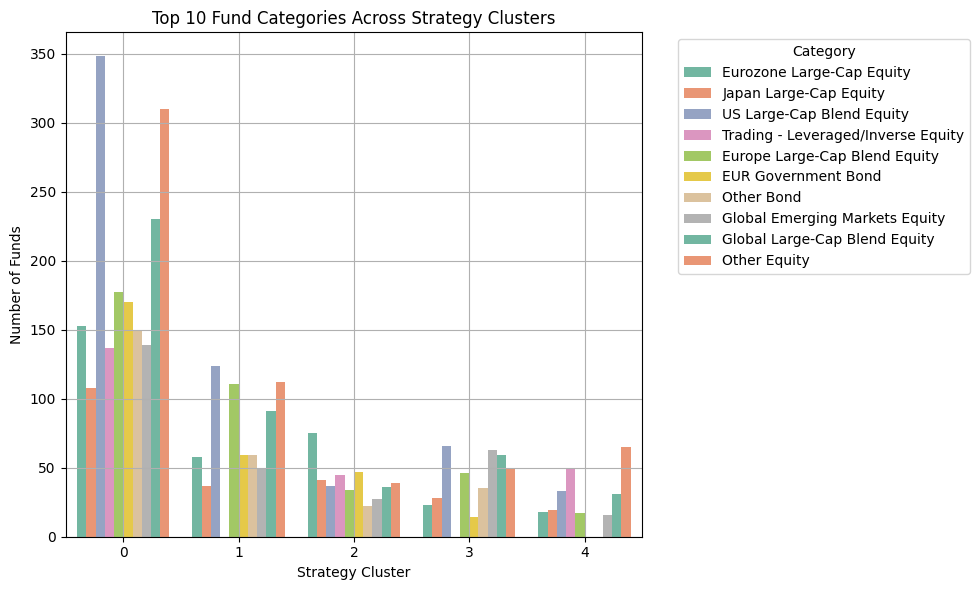

In [37]:
import seaborn as sns

top_categories = df["category"].value_counts().nlargest(10).index
df_top = df[df["category"].isin(top_categories)]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_top, x="strategy_cluster", hue="category", palette="Set2")
plt.title("Top 10 Fund Categories Across Strategy Clusters")
plt.xlabel("Strategy Cluster")
plt.ylabel("Number of Funds")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()

<ipython-input-38-0ecef9402aa1>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="strategy_cluster", y="risk_score", estimator="mean", palette="muted")


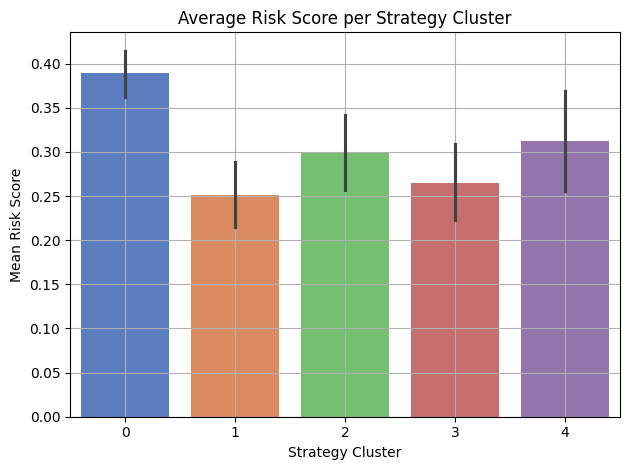

In [38]:
sns.barplot(data=df, x="strategy_cluster", y="risk_score", estimator="mean", palette="muted")
plt.title("Average Risk Score per Strategy Cluster")
plt.xlabel("Strategy Cluster")
plt.ylabel("Mean Risk Score")
plt.grid(True)
plt.tight_layout()
plt.show()